In [4]:
#Import the libraries
import datetime as dt           # Permite trabajar con fechas
from datetime import date
import pandas as pd             # Manipulacion de datos
import numpy as np              # Manipulacion de datos
import matplotlib.pyplot as plt # Construcción de gráficas
import seaborn as sns
import json
from pathlib import Path
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from pyproj import Transformer
from geopy.geocoders import Nominatim
import cartopy.crs as ccrs
#API de XM
from pydataxm import *          # Importa la libreria que fue instalada con pip install pydataxm o tambien desde GitHub
#PyPsa
import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

In [5]:
# Se carga la información de Paratec (XM) de líneas de transmisión de 220 kV, 230 kV y 500 kV
# Cargar el archivo Excel
file_path = 'Lineas_Transmisión(actualizado).xlsx'
line_data = pd.read_excel(file_path, sheet_name='Lineas', usecols=range(17))

# Expresión regular para eliminar las partes " 220 kV", " 230 kV" y " 500 kV"
line_data['OPERADOR'] = line_data['OPERADOR'].str.replace(r' (220|230|500) (kV|KV)', '', regex=True)

# Crear la columna 'N_PARALELAS' extrayendo el último dígito
line_data['N_PARALELAS'] = line_data['OPERADOR'].str.extract(r'(\d)$')

# Convertir la columna 'N_PARALELAS' a tipo numérico
line_data['N_PARALELAS'] = pd.to_numeric(line_data['N_PARALELAS'])

# Quitar el sufijo del nombre de la línea (número de sentido)
line_data['OPERADOR'] = line_data['OPERADOR'].str.replace(r' \d$', '', regex=True)

# Eliminar las filas duplicadas, manteniendo las que tienen mayor número de líenas paralelas
line_data = line_data.drop_duplicates(subset=['OPERADOR'], keep='last')

# Extraer el año y reemplazar la columna de fechas con el valor del año
line_data['FECHA DE ENTRADA'] = line_data['FECHA DE ENTRADA'].dt.year

#pd.set_option("display.max_rows", None)
line_data['CAPACIDAD TRANSPORTE PARA POTENCIA'] = np.sqrt(3) * line_data['CAPACIDAD TRANSPORTE NOMINAL (A)'] * line_data['NIVEL DE TENSIÓN (kV)'] *0.9 / 1000
line_data['CAPACIDAD MAXIMA TRANSPORTE PARA POTENCIA'] = np.sqrt(3) * line_data['CAPACIDAD TRANSPORTE EMERGENCIA (A)'] * line_data['NIVEL DE TENSIÓN (kV)'] *0.9 / 1000 / line_data['CAPACIDAD TRANSPORTE PARA POTENCIA'] 
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

line_data

,OPERADOR,NIVEL DE TENSIÓN (kV),TIPO (km),LONGITUD (km),CAPACIDAD TRANSPORTE NOMINAL (A),CAPACIDAD TRANSPORTE TÉRMICO (A),CAPACIDAD TRANSPORTE EMERGENCIA (A),R1 (Ω/km),X1 (Ω/km),B1 (uS/km),R0 (Ω/km),X0 (Ω/km),B0 (uS/km),USO,ELEMENTO QUE IMPONE LIMITE,COMPARTE ESTRUCTURA,FECHA DE ENTRADA,N_PARALELAS,CAPACIDAD TRANSPORTE PARA POTENCIA,CAPACIDAD MAXIMA TRANSPORTE PARA POTENCIA
0,ALFEREZ (EEB) - SAN BERNARDINO,230,Aérea,101.03,1003.0,1003.0,1303.9,0.0469,0.4690,3.5726,0.3786,1.3304,2.1836,Uso,Línea de transmisión,Si,2014,1,359.610121,1.300000
2,ALFEREZ (EEB) - TESALIA,230,Aérea,200.78,1040.0,1040.0,1040.0,0.0501,0.4956,3.3744,0.3849,1.3291,2.1303,Uso,Línea de transmisión,Si,2022,2,372.875898,1.000000
3,ALFEREZ (EEB) - YUMBO,230,Aérea,24.54,1003.0,1003.0,1303.9,0.0469,0.4690,3.5726,0.3786,1.3304,2.1836,Uso,Línea de transmisión,Si,2014,1,359.610121,1.300000
4,ALTAMIRA - BETANIA,230,Aérea,82.59,1040.0,1381.0,1795.0,0.0478,0.3586,4.7210,0.4193,1.5655,2.7675,Uso,Sin definir,No,2007,1,372.875898,1.725962
5,ALTAMIRA - RENACER,230,Aérea,144.52,1040.0,1383.0,1798.0,0.0471,0.3594,4.6335,0.3187,1.3721,2.4890,Uso,Línea de transmisión,Si,2007,1,372.875898,1.728846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,SAN MATEO (CUCUTA) - TASAJERO,230,Aérea,18.75,860.0,860.0,860.0,0.0666,0.4946,3.3420,0.2890,0.9240,2.6960,Uso,Línea de transmisión,No,1984,1,308.339685,1.000000
263,SANTA MARTA - TERMOCOL,220,Aérea,11.56,656.0,813.0,787.0,0.0887,0.4934,3.3200,0.4172,1.2423,1.9540,Uso,Sin definir,Si,2013,1,224.972615,1.199695
265,TERMOCANDELARIA - TERNERA,220,Aérea,3.12,787.0,813.0,790.0,0.0896,0.4955,3.3608,0.3396,1.1377,2.1048,Uso,Sin definir,Si,2000,2,269.898549,1.003812
267,TERMOFLORES - NUEVA BARRANQUILLA,220,Aérea,7.40,840.0,890.0,890.0,0.0885,0.4658,3.5795,0.2591,1.6223,2.1053,Uso,Sin definir,Si,1999,2,288.074690,1.059524


In [6]:
# Crear una nueva red en PyPSA
network = pypsa.Network()

# Añadir buses a la red (a partir de la columna 'OPERADOR')
buses = set()
for idx, row in line_data.iterrows():
    buses.update(row['OPERADOR'].split(' - '))

for bus in buses:
    network.add("Bus", bus)

# Añadir líneas de transmisión
for idx, row in line_data.iterrows():
    buses = row['OPERADOR'].split(' - ')
    from_bus = buses[0]
    to_bus = buses[1] if len(buses) > 1 else f"Bus_{idx}"
    network.add("Line",
                f"Line_{idx}",
                bus0=from_bus,
                bus1=to_bus,
                r=row['R1 (Ω/km)'],
                x=row['X1 (Ω/km)'],
                b=row['B1 (uS/km)'],
                s_nom = row['CAPACIDAD TRANSPORTE PARA POTENCIA'],
                s_max_pu = row['CAPACIDAD MAXIMA TRANSPORTE PARA POTENCIA'],
                #s_nom_mod = row['CAPACIDAD TRANSPORTE EMERGENCIA (A)'],
                length = row['LONGITUD (km)'],
                build_year = row['FECHA DE ENTRADA'], # Use the processed build_year
                num_parallel = row['N_PARALELAS'],
                carrier = "AC"
                )

# Mostrar un resumen de la red creada
#print(network.buses)
#print(network.lines)

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x2997cd983d0>,
 <matplotlib.collections.LineCollection at 0x2997cce8b90>)

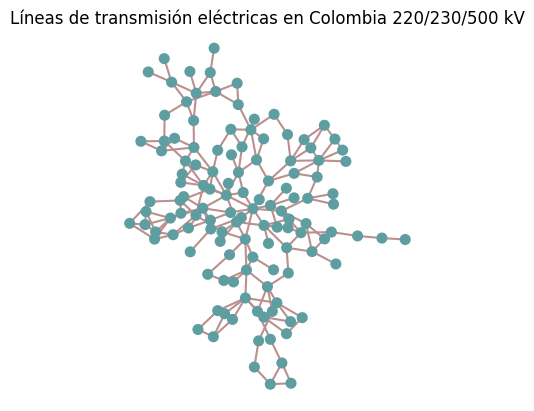

In [7]:
network.plot(title="Líneas de transmisión eléctricas en Colombia 220/230/500 kV", bus_sizes=0.001)

In [8]:
with open('SUBESTACIONES.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extraer los datos de atributos
attributes = [feature['attributes'] for feature in data['features']]

# Crear el DataFrame
data = pd.DataFrame(attributes)

# Mostrar el DataFrame
#data = data[data['TENSION_NO'] == 500]
data

,OBJECTID,OBJECTID_1,EST,MUNICIPIO,DEPARTAMEN,TENSION_NO,CONFIGURAC,ANOENTRADA,OPRED,NOTAS,...,NOM_SUBEST,ORGANIZACI,TENSION_SU,ESTADO,FECHA_OPER,OBSERVACIO,COD_DPTO,COD_MPIO,LATITUD_1,LONGITUD_1
0,1,2.0,BETANIA,YAGUARA,HUILA,230,,,CHB,,...,BETANIA,CHB,230/115/13.8,1.0,-2036361600000,,,,0.0,0.0
1,2,3.0,TERMOCENTRO,CIMITARRA,SANTANDER,230,,,ISAGEN,,...,TERMOCENTRO,ISAGEN,230,1.0,-2209248000000,,,,0.0,0.0
2,3,4.0,JAGUAS,SAN RAFAEL,ANTIOQUIA,230,,,ISAGEN,,...,JAGUAS,ISAGEN,230/13.8,1.0,-2209248000000,,,,0.0,0.0
3,4,5.0,MERILECTRICA,BARRANCABERMEJA,SANTANDER,230,,,MERILCTRICA,,...,MERILECTRICA,MERILCTRICA,230,1.0,-2209248000000,,,,0.0,0.0
4,5,6.0,BARRANQUILLA,BARRANQUILLA,ATLANTICO,220,INTERRUPTOR Y MEDIO (220 KV) y DOB,1999,Transelca,,...,BARRANQUILLA,Transelca,220/110,1.0,946512000000,,,,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,98.0,RUBIALES,PUERTO GAITAN,META,220,,,PEL,,...,RUBIALES,PEL,220,1.0,-2209248000000,,,,0.0,0.0
96,97,99.0,JAGUEY,TAURAMENA,CASANARE,220,,,PEL,,...,JAGUEY,PEL,220,1.0,-2209248000000,,,,0.0,0.0
97,98,100.0,QUIFA,PUERTO GAITAN,META,220,,,PEL,,...,QUIFA,PEL,220,1.0,-2209248000000,,,,0.0,0.0
98,99,101.0,COROCORA,PUERTO GAITAN,META,220,,,PEL,,...,COROCORA,PEL,220,1.0,-2209248000000,,,,0.0,0.0


In [9]:
# Cargar el archivo Excel
# Añadir las coordenadas a los buses en la red PyPSA
for idx, row in data.iterrows():
    bus_name = row['NOM_SUBEST']
    if bus_name in network.buses.index:
        network.buses.at[bus_name, 'x'] = row['LONGITUD']
        network.buses.at[bus_name, 'y'] = row['LATITUD']
        network.buses.at[bus_name, 'v_nom'] = row['TENSION_NO']
        network.buses.at[bus_name, 'carrier'] = "AC"

#pd.set_option('display.max_rows', None)
network.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
HIDROSOGAMOSO,1.0,,0.000000,0.000000,AC,,1.0,0.0,inf,PQ,,
ANCON SUR (EPM),220.0,,-75.638500,6.151600,AC,,1.0,0.0,inf,PQ,,
PORTON DEL SOL,1.0,,0.000000,0.000000,AC,,1.0,0.0,inf,PQ,,
RIO CORDOBA,1.0,,0.000000,0.000000,AC,,1.0,0.0,inf,PQ,,
TOLUVIEJO,1.0,,0.000000,0.000000,AC,,1.0,0.0,inf,PQ,,
...,...,...,...,...,...,...,...,...,...,...,...,...
EL BOSQUE,220.0,,-75.521528,10.409453,AC,,1.0,0.0,inf,PQ,,
SAN BERNARDINO,230.0,,-76.593544,2.498783,AC,,1.0,0.0,inf,PQ,,
BANADIA,230.0,,-71.812098,6.937214,AC,,1.0,0.0,inf,PQ,,


c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x2997cec58d0>,
 <matplotlib.collections.LineCollection at 0x2997cea5090>)

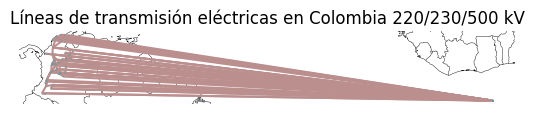

In [10]:
# En la siguiente gráfica, se puede notar que varias subestaciones no tienen coordenadas definidas (están en 0)
network.plot(title="Líneas de transmisión eléctricas en Colombia 220/230/500 kV", bus_sizes=0.01)

In [11]:
# Crear un transformador de EPSG:3857 a EPSG:4326
#transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
#transformer.transform(-8427237.262,552791.246)

# Se agregan y corrigen las coordenadas correspondientes
network.buses.at["ESMERALDA", 'x'] = -75.72765136682702
network.buses.at["ESMERALDA", 'y'] = 5.040109266108566

network.buses.at["VARIANTE", 'x'] = -75.19225204697618
network.buses.at["VARIANTE", 'y'] = 6.203272099575962
network.buses.at["VARIANTE", 'v_nom'] = 230

network.buses.at["SAHAGUN", 'x'] = -75.46135119859517
network.buses.at["SAHAGUN", 'y'] = 8.64651402699934
network.buses.at["SAHAGUN", 'v_nom'] = 500

network.buses.at["GUAYABAL", 'x'] = -75.58030959631222
network.buses.at["GUAYABAL", 'y'] = 6.207639783598726
network.buses.at["GUAYABAL", 'v_nom'] = 230

network.buses.at["EL RIO", 'x'] = -74.76547842411088
network.buses.at["EL RIO", 'y'] = 10.984101275236384
network.buses.at["EL RIO", 'v_nom'] = 220

network.buses.at["SAN ANTONIO", 'x'] = -72.89623848594114
network.buses.at["SAN ANTONIO", 'y'] = 5.760304612514933
network.buses.at["SAN ANTONIO", 'v_nom'] = 230

network.buses.at["RENACER", 'x'] = -76.65620440570456
network.buses.at["RENACER", 'y'] = 1.1740587644315916
network.buses.at["RENACER", 'v_nom'] = 230

network.buses.at["PALENQUE", 'x'] = -73.16635199228357
network.buses.at["PALENQUE", 'y'] = 7.097605000737938
network.buses.at["PALENQUE", 'v_nom'] = 230

network.buses.at["PORTON DEL SOL", 'x'] = -74.71872396384778
network.buses.at["PORTON DEL SOL", 'y'] = 5.412190248472682
network.buses.at["PORTON DEL SOL", 'v_nom'] = 230

network.buses.at["LA SIERRA (ANTIOQUIA)", 'x'] = -74.56153272757813
network.buses.at["LA SIERRA (ANTIOQUIA)", 'y'] = 6.235894951678483
network.buses.at["LA SIERRA (ANTIOQUIA)", 'v_nom'] = 230

network.buses.at["GUAVIO SUBT DUCTO", 'x'] = -73.3571780118966
network.buses.at["GUAVIO SUBT DUCTO", 'y'] = 4.735756092414423
network.buses.at["GUAVIO SUBT DUCTO", 'v_nom'] = 230

network.buses.at["LA CIRA INFANTAS", 'x'] = -73.77983555562145
network.buses.at["LA CIRA INFANTAS", 'y'] = 6.998183415195843
network.buses.at["LA CIRA INFANTAS", 'v_nom'] = 230

network.buses.at["NUEVA BARRANQUILLA", 'x'] = -74.83980702791642
network.buses.at["NUEVA BARRANQUILLA", 'y'] = 10.991587526894437
network.buses.at["NUEVA BARRANQUILLA", 'v_nom'] = 220

network.buses.at["TESORITO", 'x'] = -75.45945353943462
network.buses.at["TESORITO", 'y'] = 8.64657849338912
network.buses.at["TESORITO", 'v_nom'] = 500

network.buses.at["RIO CORDOBA", 'x'] = -74.20592517208262
network.buses.at["RIO CORDOBA", 'y'] = 11.023536060811589
network.buses.at["RIO CORDOBA", 'v_nom'] = 220

network.buses.at["HIDROSOGAMOSO", 'x'] = -73.40681373532352
network.buses.at["HIDROSOGAMOSO", 'y'] = 7.1004330385501015
network.buses.at["HIDROSOGAMOSO", 'v_nom'] = 230

network.buses.at["SOGAMOSO", 'x'] = -73.46077801583087
network.buses.at["SOGAMOSO", 'y'] = 7.1223725078310824
network.buses.at["SOGAMOSO", 'v_nom'] = 500

network.buses.at["IBAGUE", 'x'] = -75.17396628378569
network.buses.at["IBAGUE", 'y'] = 4.403028512341808
network.buses.at["IBAGUE", 'v_nom'] = 230

network.buses.at["PIMAMPIRO", 'x'] = -77.94581593874138
network.buses.at["PIMAMPIRO", 'y'] = 0.40918402964757083
network.buses.at["PIMAMPIRO", 'v_nom'] = 230

network.buses.at["HELICONIA", 'x'] = -75.77461046137178
network.buses.at["HELICONIA", 'y'] = 6.243468113245842
network.buses.at["HELICONIA", 'v_nom'] = 500

network.buses.at["CASA DE MAQUINAS JAGUAS", 'x'] = -75.00435905959985
network.buses.at["CASA DE MAQUINAS JAGUAS", 'y'] = 6.354864998510647
network.buses.at["CASA DE MAQUINAS JAGUAS", 'v_nom'] = 230

network.buses.at["MIEL I", 'x'] = -74.88893354640508
network.buses.at["MIEL I", 'y'] = 5.565499935946112

network.buses.at["CASA MAQUINAS MIEL I", 'x'] = -74.88736493160926
network.buses.at["CASA MAQUINAS MIEL I", 'y'] = 5.56172036050453
network.buses.at["CASA MAQUINAS MIEL I", 'v_nom'] = 230

network.buses.at["TULUNI", 'x'] = -75.47445763612325
network.buses.at["TULUNI", 'y'] = 3.7191947742599614
network.buses.at["TULUNI", 'v_nom'] = 230

network.buses.at["TOLUVIEJO", 'x'] = -75.46084048838985
network.buses.at["TOLUVIEJO", 'y'] = 9.455771452162256
network.buses.at["TOLUVIEJO", 'v_nom'] = 230

network.buses.at["SAN JUAN (GEB)", 'x'] = -73.02709557032229
network.buses.at["SAN JUAN (GEB)", 'y'] = 10.767843127675368
network.buses.at["SAN JUAN (GEB)", 'v_nom'] = 220

network.buses.at["LA LOMA", 'x'] = -73.61750207983509
network.buses.at["LA LOMA", 'y'] = 9.59927954659304
network.buses.at["LA LOMA", 'v_nom'] = 500

network.buses.at["ALTO ANCHICAYA", 'x'] = -76.86749933830937
network.buses.at["ALTO ANCHICAYA", 'y'] = 3.533702551819613
network.buses.at["ALTO ANCHICAYA", 'v_nom'] = 220

network.buses.at["ANTIOQUIA", 'x'] = -75.65682035538829
network.buses.at["ANTIOQUIA", 'y'] = 7.13539384052689
network.buses.at["ANTIOQUIA", 'v_nom'] = 500

network.buses.at["NUEVA ESPERANZA", 'x'] = -74.28441199355242
network.buses.at["NUEVA ESPERANZA", 'y'] = 4.573537863342697
network.buses.at["NUEVA ESPERANZA", 'v_nom'] = 500

network.buses.at["ARMENIA", 'x'] = -75.67202556328081
network.buses.at["ARMENIA", 'y'] = 4.5560295009165035
network.buses.at["ARMENIA", 'v_nom'] = 230

network.buses.at["EL QUIMBO", 'x'] = -75.56442452866764
network.buses.at["EL QUIMBO", 'y'] = 2.4531753893745316
network.buses.at["EL QUIMBO", 'v_nom'] = 230

network.buses.at["TESALIA", 'x'] = -75.58180535181174
network.buses.at["TESALIA", 'y'] = 2.4606911119014763
network.buses.at["TESALIA", 'v_nom'] = 230

network.buses.at["MONTERIA (ISA)", 'x'] = -75.85748477489666
network.buses.at["MONTERIA (ISA)", 'y'] = 8.75564851857695
network.buses.at["MONTERIA (ISA)", 'v_nom'] = 220

network.buses.at["CARACOLI", 'x'] = -74.82930084253195
network.buses.at["CARACOLI", 'y'] = 10.891293302814194
network.buses.at["CARACOLI", 'v_nom'] = 220

network.buses.at["CASA MAQUINAS SAN CARLOS", 'x'] = -74.83962594325848
network.buses.at["CASA MAQUINAS SAN CARLOS", 'y'] = 6.215425851295978
network.buses.at["CASA MAQUINAS SAN CARLOS", 'v_nom'] = 230

network.buses.at["SURIA (DELSUR)", 'x'] = -73.4404739524194
network.buses.at["SURIA (DELSUR)", 'y'] = 4.060922867524979
network.buses.at["SURIA (DELSUR)", 'v_nom'] = 220

network.buses.at["PORCE III", 'x'] = -75.1020059417956
network.buses.at["PORCE III", 'y'] = 6.983656001778746

network.buses.at["BALSILLAS", 'x'] = -74.25920793494686
network.buses.at["BALSILLAS", 'y'] = 4.683959539467804

network.buses.at["CASA MAQUINAS PORCE III", 'x'] = -75.1404674979053
network.buses.at["CASA MAQUINAS PORCE III", 'y'] = 6.940930527922869
network.buses.at["CASA MAQUINAS PORCE III", 'v_nom'] = 500

network.buses.at["ANCON SUR (EPM)", 'x'] = -75.63206987467917
network.buses.at["ANCON SUR (EPM)", 'y'] = 6.147002250804893
network.buses.at["ANCON SUR (EPM)", 'v_nom'] = 220

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



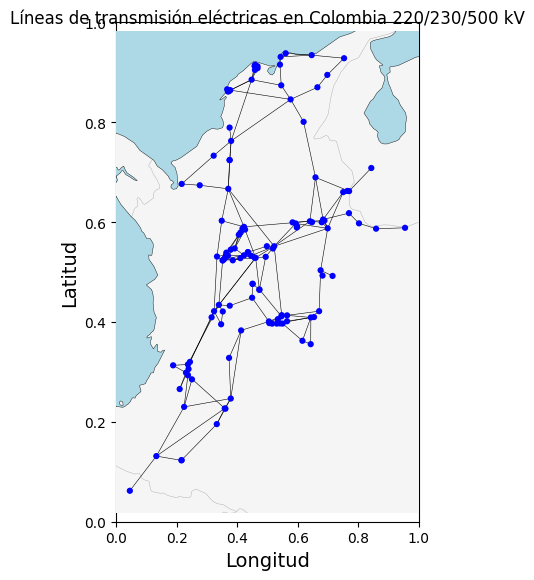

In [12]:
# Con la siguiente gráfica, se confirma que la red de Colombia se replicó correctamente
# Se puede comparar con el mapa de ISA de este enlace: https://www.isaintercolombia.com/mapa-red-en-operacion/
# Configurar el tamaño y estilo del plot
plt.figure(figsize=(4, 6))
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Latitud", fontsize=14)

# Plotear la red
network.plot(
    bus_sizes=0.006,                # Tamaño de los buses
    line_widths=0.4,              # Ancho de las líneas
    line_colors='k',              # Color de las líneas (negro)
    bus_colors='blue',             # Color de los buses (rojo)
    geomap = True,
    color_geomap=True,
    title="Líneas de transmisión eléctricas en Colombia 220/230/500 kV",
)

# Mejorar el diseño del plot
plt.grid(True)
plt.tight_layout()

# Guardar la figura
plt.savefig("lineas_transmision_colombia.png", dpi=300)

# Mostrar el plot
plt.show()

In [13]:
# creando el objeto de fecha desde que comienza el analisis
start_date = date(2024, 1, 1)
# creando el objeto de fecha de la fecha de hoy
end_date = date(2024, 11, 3)

In [14]:
objetoAPI = pydataxm.ReadDB()  # Se asigna un objeto que pueda realizar el consumo de la data en la API

In [15]:
#pd.set_option('display.max_rows', None)
objetoAPI.get_collections()
#objetoAPI.get_collections().to_excel('Variables_XM.xlsx', sheet_name='VARIABLES', index=True)

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
0,DemaReal,Demanda Real por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Demanda de usuarios regulados y no regulados q...
1,DemaReal,Demanda Real por Agente,Agente,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Comercializador,kWh,Demanda de usuarios regulados y no regulados q...
2,ExpoMoneda,Exportaciones Moneda por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,Transferencias de Energia desde Colombia hacia...
3,DemaCome,Demanda Comercial por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Considera la demanda propia de cada comerciali...
4,Gene,Generación por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...
...,...,...,...,...,...,...,...,...,...
185,ListadoAgentes,Listado de agentes con atributos por Sistema,Sistema,731,ListsEntities,http://servapibi.xm.com.co/list,No aplica,,Listado de Agentes registrados ante el ASIC co...
186,ListadoRios,Listado de rios por Sistema,Sistema,731,ListsEntities,http://servapibi.xm.com.co/list,No aplica,,Listado de ríos que se encuentran registrados ...
187,ListadoEmbalses,Listado de embalses por Sistema,Sistema,731,ListsEntities,http://servapibi.xm.com.co/list,No aplica,,Listado de embalses que se encuentran registra...
188,ListadoMetricas,Listado de Métricas por Sistema,Sistema,731,ListsEntities,http://servapibi.xm.com.co/list,No aplica,,Listado de métricas disponibles en la API XM c...


In [16]:
#Se recolecta la información de generados que despachan al SIN y que se encuentran en operación
df_XM = objetoAPI.request_data('ListadoRecursos','Sistema', dt.date(start_date.year, start_date.month, start_date.day),dt.date(end_date.year, end_date.month, end_date.day))
df_XM = df_XM[(df_XM['Values_Disp'] == 'DESPACHADO CENTRALMENTE') & (df_XM['Values_State'] == 'OPERACION')]
df_XM = df_XM.drop('Id', axis=1)
df_XM = df_XM.drop('Values_Disp', axis=1)
df_XM = df_XM.drop('Values_State', axis=1)
df_XM.set_index('Date', inplace=True)
df_XM

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead



,Values_Code,Values_Name,Values_Type,Values_RecType,Values_CompanyCode,Values_EnerSource,Values_OperStartdate
Date,,,,,,,
2025-01-11,2QEK,SALTO II,HIDRAULICA,FILO DE AGUA,ENDG,AGUA,2014-06-25
2025-01-11,3DDT,LATAM SOLAR LA LOMA,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24
2025-01-11,3ENA,TESORITO,TERMICA,NORMAL,EPSG,GAS,2022-09-13
2025-01-11,3HF5,FUNDACION,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24
2025-01-11,3INX,CARACOLI I,SOLAR,NORMAL,SDCG,RAD SOLAR,2024-12-22
...,...,...,...,...,...,...,...
2025-01-11,URA1,URRA,HIDRAULICA,NORMAL,EMUG,AGUA,2000-02-14
2025-01-11,ZPA2,ZIPAEMG 2,TERMICA,NORMAL,ENDG,CARBON,1964-01-01
2025-01-11,ZPA3,ZIPAEMG 3,TERMICA,NORMAL,ENDG,CARBON,1976-01-01


In [17]:
# Se recolecrta la información de capacidad efectiva neta de cada recurso
df_cap = objetoAPI.request_data('CapEfecNeta','Recurso', dt.date(end_date.year, end_date.month, end_date.day-2),dt.date(end_date.year, end_date.month, end_date.day-2))
df_cap = df_cap.fillna(0)
df_cap.set_index('Date', inplace=True)
df_cap = df_cap.drop('Id', axis=1)
df_cap = df_cap.rename(columns={'Code': 'Values_Code'})
df_cap = df_cap.rename(columns={'Value': 'Values_Capacidad (MW)'})
df_cap['Values_Capacidad (MW)']=df_cap['Values_Capacidad (MW)']/1000
df_cap

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

c:\Users\juanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead



,Values_Code,Values_Capacidad (MW)
Date,,
2024-11-01,2QBW,19.9
2024-11-01,2QEK,35.0
2024-11-01,2QRL,0.7
2024-11-01,2QV2,19.9
2024-11-01,2R22,18.0
...,...,...
2024-11-01,VNTB,2.5
2024-11-01,ZPA2,36.0
2024-11-01,ZPA3,63.0


In [18]:
#Se combina la información
df_generacion = pd.merge(df_XM, df_cap, on='Values_Code')
df_generacion

,Values_Code,Values_Name,Values_Type,Values_RecType,Values_CompanyCode,Values_EnerSource,Values_OperStartdate,Values_Capacidad (MW)
0,2QEK,SALTO II,HIDRAULICA,FILO DE AGUA,ENDG,AGUA,2014-06-25,35.0
1,3DDT,LATAM SOLAR LA LOMA,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24,150.0
2,3ENA,TESORITO,TERMICA,NORMAL,EPSG,GAS,2022-09-13,200.0
3,3HF5,FUNDACION,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24,90.0
4,3IRX,PORTON DEL SOL,SOLAR,NORMAL,PDSG,RAD SOLAR,2024-03-08,102.0
...,...,...,...,...,...,...,...,...
71,URA1,URRA,HIDRAULICA,NORMAL,EMUG,AGUA,2000-02-14,338.0
72,ZPA2,ZIPAEMG 2,TERMICA,NORMAL,ENDG,CARBON,1964-01-01,36.0
73,ZPA3,ZIPAEMG 3,TERMICA,NORMAL,ENDG,CARBON,1976-01-01,63.0
74,ZPA4,ZIPAEMG 4,TERMICA,NORMAL,ENDG,CARBON,1981-04-01,64.0


In [19]:
#Se asocia cada generador a un bus mediante coincidencia de nombres fuzzywuzzy
buses_names = {'nombres': network.buses.index}
buses_names = pd.DataFrame(buses_names)
for idx, row in df_generacion.iterrows():
    subEst_name = row['Values_Name']
    # Usar fuzzywuzzy para encontrar la coincidencia más cercana
    mejor_coincidencia = process.extractOne(subEst_name, buses_names['nombres'])
    if mejor_coincidencia[1]>70:
        df_generacion.loc[idx, 'Values_Bus'] = mejor_coincidencia[0]
#pd.set_option('display.max_rows', None)
df_generacion

,Values_Code,Values_Name,Values_Type,Values_RecType,Values_CompanyCode,Values_EnerSource,Values_OperStartdate,Values_Capacidad (MW),Values_Bus
0,2QEK,SALTO II,HIDRAULICA,FILO DE AGUA,ENDG,AGUA,2014-06-25,35.0,EL SALTO (EPM)
1,3DDT,LATAM SOLAR LA LOMA,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24,150.0,LA LOMA
2,3ENA,TESORITO,TERMICA,NORMAL,EPSG,GAS,2022-09-13,200.0,TESORITO
3,3HF5,FUNDACION,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24,90.0,FUNDACION
4,3IRX,PORTON DEL SOL,SOLAR,NORMAL,PDSG,RAD SOLAR,2024-03-08,102.0,PORTON DEL SOL
...,...,...,...,...,...,...,...,...,...
71,URA1,URRA,HIDRAULICA,NORMAL,EMUG,AGUA,2000-02-14,338.0,URRA
72,ZPA2,ZIPAEMG 2,TERMICA,NORMAL,ENDG,CARBON,1964-01-01,36.0,NaN
73,ZPA3,ZIPAEMG 3,TERMICA,NORMAL,ENDG,CARBON,1976-01-01,63.0,NaN
74,ZPA4,ZIPAEMG 4,TERMICA,NORMAL,ENDG,CARBON,1981-04-01,64.0,NaN


In [20]:
#Se puede notar que varios generadores no tienen buses asignados, o están asociados incorrectamente.
#A continuación, se ajusta manualmente.
df_generacion.loc[0, 'Values_Bus'] = 'NUEVA ESPERANZA'
df_generacion.loc[5, 'Values_Bus'] = 'MONTERIA (ISA)'
df_generacion.loc[6, 'Values_Bus'] = 'ALTO ANCHICAYA'
df_generacion.loc[9, 'Values_Bus'] = 'BARBOSA (ANTIOQUIA)'
df_generacion.loc[10, 'Values_Bus'] = 'SAN MARCOS (VALLE)'
df_generacion.loc[14, 'Values_Bus'] = 'IBAGUE'
df_generacion.loc[15, 'Values_Bus'] = 'LA GUACA'
df_generacion.loc[16, 'Values_Bus'] = 'LA LOMA'
df_generacion.loc[18:19, 'Values_Bus'] = 'CERROMATOSO'
df_generacion.loc[21, 'Values_Bus'] = 'GUADALUPE IV'
df_generacion.loc[23, 'Values_Bus'] = 'ORIENTE'
df_generacion.loc[24, 'Values_Bus'] = 'CASA MAQUINAS MIEL I'
df_generacion.loc[25, 'Values_Bus'] = 'CASA DE MAQUINAS JAGUAS'
df_generacion.loc[27, 'Values_Bus'] = 'OCAÑA'
df_generacion.loc[28, 'Values_Bus'] = 'TULUNI'
df_generacion.loc[30, 'Values_Bus'] = 'ANTIOQUIA'
df_generacion.loc[31, 'Values_Bus'] = 'PARAISO'
df_generacion.loc[37, 'Values_Bus'] = 'PORCE II (EEPPM)'
df_generacion.loc[38, 'Values_Bus'] = 'CASA MAQUINAS PORCE III'
df_generacion.loc[39, 'Values_Bus'] = 'LA GUACA'
df_generacion.loc[40:41, 'Values_Bus'] = 'CARTAGENA'
df_generacion.loc[43, 'Values_Bus'] = 'ANCON SUR (ISA)'
df_generacion.loc[45, 'Values_Bus'] = 'GUATAPE'
df_generacion.loc[46, 'Values_Bus'] = 'CASA MAQUINAS SAN CARLOS'
df_generacion.loc[47, 'Values_Bus'] = 'ESMERALDA'
df_generacion.loc[52, 'Values_Bus'] = 'BOLIVAR'
df_generacion.loc[54, 'Values_Bus'] = 'PURNIO'
df_generacion.loc[55, 'Values_Bus'] = 'SAN MARCOS (VALLE)'
df_generacion.loc[56:57, 'Values_Bus'] = 'TERMOFLORES'
df_generacion.loc[60, 'Values_Bus'] = 'PURNIO'
df_generacion.loc[62, 'Values_Bus'] = 'TERMOCOL'
df_generacion.loc[65, 'Values_Bus'] = 'LA SIERRA (ANTIOQUIA)'
df_generacion.loc[66, 'Values_Bus'] = 'SAN MARCOS (VALLE)'
df_generacion.loc[67:71, 'Values_Bus'] = 'SAN ANTONIO'
df_generacion.loc[73:76, 'Values_Bus'] = 'BACATA'

df_generacion

,Values_Code,Values_Name,Values_Type,Values_RecType,Values_CompanyCode,Values_EnerSource,Values_OperStartdate,Values_Capacidad (MW),Values_Bus
0,2QEK,SALTO II,HIDRAULICA,FILO DE AGUA,ENDG,AGUA,2014-06-25,35.0,NUEVA ESPERANZA
1,3DDT,LATAM SOLAR LA LOMA,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24,150.0,LA LOMA
2,3ENA,TESORITO,TERMICA,NORMAL,EPSG,GAS,2022-09-13,200.0,TESORITO
3,3HF5,FUNDACION,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24,90.0,FUNDACION
4,3IRX,PORTON DEL SOL,SOLAR,NORMAL,PDSG,RAD SOLAR,2024-03-08,102.0,PORTON DEL SOL
...,...,...,...,...,...,...,...,...,...
71,URA1,URRA,HIDRAULICA,NORMAL,EMUG,AGUA,2000-02-14,338.0,SAN ANTONIO
72,ZPA2,ZIPAEMG 2,TERMICA,NORMAL,ENDG,CARBON,1964-01-01,36.0,NaN
73,ZPA3,ZIPAEMG 3,TERMICA,NORMAL,ENDG,CARBON,1976-01-01,63.0,BACATA
74,ZPA4,ZIPAEMG 4,TERMICA,NORMAL,ENDG,CARBON,1981-04-01,64.0,BACATA


In [21]:
# Se reduce la fecha de entrada en operación a solo el año
df_generacion['Values_OperStartyear'] = df_generacion['Values_OperStartdate'].str[:4].astype(int, errors='ignore')

In [22]:
df_generacion

,Values_Code,Values_Name,Values_Type,Values_RecType,Values_CompanyCode,Values_EnerSource,Values_OperStartdate,Values_Capacidad (MW),Values_Bus,Values_OperStartyear
0,2QEK,SALTO II,HIDRAULICA,FILO DE AGUA,ENDG,AGUA,2014-06-25,35.0,NUEVA ESPERANZA,2014
1,3DDT,LATAM SOLAR LA LOMA,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24,150.0,LA LOMA,2024
2,3ENA,TESORITO,TERMICA,NORMAL,EPSG,GAS,2022-09-13,200.0,TESORITO,2022
3,3HF5,FUNDACION,SOLAR,NORMAL,ENDG,RAD SOLAR,2024-06-24,90.0,FUNDACION,2024
4,3IRX,PORTON DEL SOL,SOLAR,NORMAL,PDSG,RAD SOLAR,2024-03-08,102.0,PORTON DEL SOL,2024
...,...,...,...,...,...,...,...,...,...,...
71,URA1,URRA,HIDRAULICA,NORMAL,EMUG,AGUA,2000-02-14,338.0,SAN ANTONIO,2000
72,ZPA2,ZIPAEMG 2,TERMICA,NORMAL,ENDG,CARBON,1964-01-01,36.0,NaN,1964
73,ZPA3,ZIPAEMG 3,TERMICA,NORMAL,ENDG,CARBON,1976-01-01,63.0,BACATA,1976
74,ZPA4,ZIPAEMG 4,TERMICA,NORMAL,ENDG,CARBON,1981-04-01,64.0,BACATA,1981


In [23]:
df_generacion.to_excel('Generacion.xlsx', sheet_name='GENERACIÓN', index=True)

In [24]:
#Datos de MPODE
#Lista de buses utilizados en el modelo
buses_mpode = pd.read_csv("dbus.csv",sep='\s+')
buses_mpode = buses_mpode.drop(['Tp','tg','%per1','Ploa1','Pind1','PerF1','%per2','Ploa2','Pind2','PerF2','%per3','Ploa3','Pind3','PerF3',
                                  '%per4','Ploa4','Pind4','PerF4','%per5','Ploa5','Pind5','PerF5','Icca'], axis=1)
buses_mpode

<>:3: DeprecationWarning:

invalid escape sequence '\s'

<>:3: DeprecationWarning:

invalid escape sequence '\s'

C:\Users\juanm\AppData\Local\Temp\ipykernel_4336\4009184230.py:3: DeprecationWarning:

invalid escape sequence '\s'



,NUM.,...NombreB..,Id,#,Plnt,Nombre,Gener.Area
0,999,Bacata500shn,co,5,NaN,NaN,NaN
1,1,Cerromia1shn,co,1,2045.0,TC_GECELCA32,1
2,2,Copey-500shn,co,1,NaN,NaN,NaN
3,3,ReaVirNvEsp,co,3,NaN,NaN,NaN
4,4,SanMatia2220,co,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...
878,716,TrfTer2063F,co,1,NaN,NaN,NaN
879,717,TrfVal2312F,co,1,NaN,NaN,NaN
880,718,TrfVal2372F,co,1,NaN,NaN,NaN
881,719,TrfVal3F,co,1,NaN,NaN,NaN


In [25]:
#Se asocia cada bus de MPODE a un bus de Pypsa mediante coincidencia de nombres fuzzywuzzy
buses_names = {'nombres': network.buses.index}
buses_names = pd.DataFrame(buses_names)
for idx, row in buses_mpode.iterrows():
    subEst_name = row['...NombreB..']
    # Usar fuzzywuzzy para encontrar la coincidencia más cercana
    mejor_coincidencia = process.extractOne(subEst_name, buses_names['nombres'])
    if mejor_coincidencia[1]>60:
        buses_mpode.loc[idx, 'Values_Bus'] = mejor_coincidencia[0]
#pd.set_option('display.max_rows', None)
buses_mpode.head()

,NUM.,...NombreB..,Id,#,Plnt,Nombre,Gener.Area,Values_Bus
0,999,Bacata500shn,co,5,NaN,NaN,NaN,BACATA
1,1,Cerromia1shn,co,1,2045.0,TC_GECELCA32,1,CERROMATOSO
2,2,Copey-500shn,co,1,NaN,NaN,NaN,EL COPEY
3,3,ReaVirNvEsp,co,3,NaN,NaN,NaN,NaN
4,4,SanMatia2220,co,4,NaN,NaN,NaN,BANADIA


In [26]:
#Varios nodos fueron asignados incorrectamente por coincidencias poco significativas o 
#confusiones, como en el caso de San Mateo de Cúcuta o Bogotá. Se corrigen manualmente:
buses_mpode.loc[4,"Values_Bus"] = np.NaN
buses_mpode.loc[12,"Values_Bus"] = np.NaN
buses_mpode.loc[29,"Values_Bus"] = np.NaN
buses_mpode.loc[39,"Values_Bus"] = np.NaN
buses_mpode.loc[41:42,"Values_Bus"] = np.NaN
buses_mpode.loc[80,"Values_Bus"] = np.NaN
buses_mpode.loc[91:92,"Values_Bus"] = np.NaN
buses_mpode.loc[95,"Values_Bus"] = np.NaN
buses_mpode.loc[99,"Values_Bus"] = np.NaN
buses_mpode.loc[104:105,"Values_Bus"] = np.NaN
buses_mpode.loc[108:113,"Values_Bus"] = np.NaN
buses_mpode.loc[116,"Values_Bus"] = "BELEN (CUCUTA)"
buses_mpode.loc[118,"Values_Bus"] = np.NaN
buses_mpode.loc[127,"Values_Bus"] = np.NaN
buses_mpode.loc[130:134,"Values_Bus"] = np.NaN
buses_mpode.loc[163,"Values_Bus"] = np.NaN
buses_mpode.loc[167,"Values_Bus"] = np.NaN
buses_mpode.loc[180,"Values_Bus"] = np.NaN
buses_mpode.loc[207,"Values_Bus"] = np.NaN
buses_mpode.loc[210,"Values_Bus"] = np.NaN
buses_mpode.loc[211,"Values_Bus"] = np.NaN
buses_mpode.loc[219,"Values_Bus"] = np.NaN
buses_mpode.loc[225,"Values_Bus"] = np.NaN
buses_mpode.loc[230,"Values_Bus"] = np.NaN
buses_mpode.loc[235:237,"Values_Bus"] = np.NaN
buses_mpode.loc[243:245,"Values_Bus"] = np.NaN
buses_mpode.loc[251,"Values_Bus"] = np.NaN
buses_mpode.loc[257:260,"Values_Bus"] = np.NaN
buses_mpode.loc[262,"Values_Bus"] = np.NaN
buses_mpode.loc[266,"Values_Bus"] = np.NaN
buses_mpode.loc[269,"Values_Bus"] = np.NaN
buses_mpode.loc[277:278,"Values_Bus"] = np.NaN
buses_mpode.loc[280,"Values_Bus"] = np.NaN
buses_mpode.loc[293,"Values_Bus"] = np.NaN
buses_mpode.loc[306,"Values_Bus"] = np.NaN
buses_mpode.loc[310,"Values_Bus"] = np.NaN
buses_mpode.loc[315,"Values_Bus"] = "SAN MATEO (CUCUTA)"
buses_mpode.loc[326,"Values_Bus"] = np.NaN
buses_mpode.loc[328:331,"Values_Bus"] = np.NaN
buses_mpode.loc[333,"Values_Bus"] = np.NaN
buses_mpode.loc[338:341,"Values_Bus"] = np.NaN
buses_mpode.loc[351:352,"Values_Bus"] = np.NaN
buses_mpode.loc[369,"Values_Bus"] = np.NaN
buses_mpode.loc[374,"Values_Bus"] = np.NaN
buses_mpode.loc[381:390,"Values_Bus"] = np.NaN
buses_mpode.loc[396,"Values_Bus"] = np.NaN
buses_mpode.loc[410,"Values_Bus"] = "PORCE II (EEPPM)"
buses_mpode.loc[412,"Values_Bus"] = np.NaN
buses_mpode.loc[429,"Values_Bus"] = np.NaN
buses_mpode.loc[441:448,"Values_Bus"] = np.NaN
buses_mpode.loc[454:456,"Values_Bus"] = np.NaN
buses_mpode.loc[465,"Values_Bus"] = np.NaN
buses_mpode.loc[480:482,"Values_Bus"] = np.NaN
buses_mpode.loc[494,"Values_Bus"] = "SAN MATEO (CUCUTA)"
buses_mpode.loc[501:510,"Values_Bus"] = np.NaN
buses_mpode.loc[513,"Values_Bus"] = np.NaN
buses_mpode.loc[531,"Values_Bus"] = np.NaN
buses_mpode.loc[539:541,"Values_Bus"] = np.NaN
buses_mpode.loc[564,"Values_Bus"] = np.NaN
buses_mpode.loc[568,"Values_Bus"] = np.NaN
buses_mpode.loc[582,"Values_Bus"] = np.NaN
buses_mpode.loc[585:588,"Values_Bus"] = np.NaN
buses_mpode.loc[602:643,"Values_Bus"] = np.NaN
buses_mpode.loc[663:686,"Values_Bus"] = np.NaN
buses_mpode.loc[697:767,"Values_Bus"] = np.NaN
buses_mpode.loc[835:857,"Values_Bus"] = np.NaN

In [27]:
buses_mpode.head()

,NUM.,...NombreB..,Id,#,Plnt,Nombre,Gener.Area,Values_Bus
0,999,Bacata500shn,co,5,NaN,NaN,NaN,BACATA
1,1,Cerromia1shn,co,1,2045.0,TC_GECELCA32,1,CERROMATOSO
2,2,Copey-500shn,co,1,NaN,NaN,NaN,EL COPEY
3,3,ReaVirNvEsp,co,3,NaN,NaN,NaN,NaN
4,4,SanMatia2220,co,4,NaN,NaN,NaN,NaN


In [28]:
#Se cuentan los buses de MPODE que hacen falta por asignar
buses_mpode['Values_Bus'].isna().sum()

685

In [29]:
#Datos de MPODE
#Lista de demandas (load) por cada bus (barra). Contiene la distribución de la demanda por barra para cada nivel de demanda. 
#Esta distribución está disponible para un solo día del año. Por esto decimos que es como una foto del despacho. 
#Se tiene que tomar como que la distribución geográfica de la demanda es estática en el tiempo a lo largo del año.
demanda_mpode = pd.read_csv("dbf005co.csv",sep='\s+')
demanda_mpode = demanda_mpode.drop(['Icca'], axis=1)
#demanda_mpode.drop(buses_mpode[buses_mpode['..Load..'] == 0].index, inplace = True)
#pd.set_option('display.max_rows', None)
demanda_mpode.head()

<>:5: DeprecationWarning:

invalid escape sequence '\s'

<>:5: DeprecationWarning:

invalid escape sequence '\s'

C:\Users\juanm\AppData\Local\Temp\ipykernel_4336\1222962729.py:5: DeprecationWarning:

invalid escape sequence '\s'



,BCod,..Bus.Name..,LCod,dd/mm/yyyy,Llev,..Load..
0,9,Aguablnca115,1,01/01/2023,1,43.31
1,9,Aguablnca115,1,01/01/2023,2,36.38
2,9,Aguablnca115,1,01/01/2023,3,33.53
3,9,Aguablnca115,1,01/01/2023,4,34.07
4,9,Aguablnca115,1,01/01/2023,5,27.83


In [30]:
#Datos de MPODE
#Para completar la asignación, se utilizan las líneas de MPODE
#Líneas/conexiones en el modelo MPODE
lineas_mpode = pd.read_csv("dcirc.csv", delim_whitespace=True)
lineas_mpode = lineas_mpode.drop(['I','C','....1','....2','....3','....4','....5','iflh','Prob(%)',
                                'Cmon','S','RPK2','PRTC','..phsmin','..phsmax'], axis=1)
lineas_mpode.head()

C:\Users\juanm\AppData\Local\Temp\ipykernel_4336\1553048689.py:4: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



,#BOR.,#BDE.NN,.RESIS.REACT,Nombre,(MW),(Num)
0,46,65,1.1874.3562,Bgran-Bosqu,9999.,195
1,65,444,2.6074.6581,Bosqu-Terne1,9999.,194
2,65,117,.994022.7823,Bosqu-Chamb1,9999.,4
3,65,117,.994022.7823,Bosqu-Chamb2,9999.,5
4,64,443,.319532.3991,Bosqu-Terne2,216.06,912


In [31]:
#Para las subestaciones de baja tensión, se asignará la subestación de alta tensión conectada más cercana.
#Para esto, se usará un algoritmo de búsqueda en anchura (BFS).
from collections import deque
def nodos_alcanzables_ordenados(nodo, df):
    # Conjunto para mantener los nodos visitados y evitar ciclos
    visitados = set()
    # Cola para manejar la exploración por niveles
    por_explorar = deque([nodo])
    # Lista para almacenar nodos en orden de cercanía
    resultado = []
    while por_explorar:
        actual = por_explorar.popleft()
        # Si no ha sido visitado, procesamos el nodo
        if actual not in visitados:
            visitados.add(actual)
            # Agregamos el nodo al resultado (en orden de visita)
            resultado.append(actual)
            # Encuentra los nodos conectados al nodo actual (como inicio o fin)
            conexiones_inicio = df[df['#BOR.'] == actual]['#BDE.NN'].tolist()
            conexiones_fin = df[df['#BDE.NN'] == actual]['#BOR.'].tolist()
            # Agrega los nodos conectados a la cola si no han sido visitados
            for vecino in conexiones_inicio + conexiones_fin:
                if vecino not in visitados:
                    por_explorar.append(vecino)
    # Devuelve los nodos alcanzables en orden de cercanía, excluyendo el nodo inicial
    return resultado[1:]  # Excluye el nodo inicial para evitar redundancia

# Ejemplo de uso para un nodo
nodo = 26
resultado = nodos_alcanzables_ordenados(nodo, lineas_mpode)
print("Nodos alcanzables desde el nodo", nodo, "en orden de cercanía:", resultado)

Nodos alcanzables desde el nodo 26 en orden de cercanía: [550, 433, 317, 416, 568, 269, 698, 699, 443, 144, 431, 430, 432, 630, 534, 381, 118, 575, 318, 315, 316, 715, 716, 64, 85, 145, 420, 589, 518, 663, 508, 444, 445, 65, 428, 440, 438, 86, 704, 705, 174, 272, 137, 536, 345, 491, 236, 46, 671, 672, 499, 627, 510, 549, 677, 678, 143, 535, 495, 253, 475, 134, 539, 504, 79, 117, 427, 498, 437, 439, 84, 66, 592, 351, 528, 552, 271, 273, 690, 264, 171, 601, 509, 238, 62, 56, 2, 541, 543, 598, 1, 546, 120, 654, 471, 119, 139, 469, 132, 358, 331, 531, 584, 189, 421, 571, 434, 422, 606, 544, 681, 682, 270, 274, 503, 172, 385, 579, 596, 604, 655, 577, 572, 689, 367, 567, 595, 122, 658, 679, 680, 620, 24, 472, 557, 653, 468, 276, 289, 225, 359, 710, 711, 712, 446, 423, 110, 718, 719, 717, 476, 155, 130, 629, 129, 131, 386, 147, 569, 407, 521, 148, 494, 496, 648, 565, 661, 588, 999, 507, 564, 611, 241, 560, 265, 25, 244, 164, 231, 362, 397, 583, 570, 176, 555, 477, 593, 387, 182, 268, 585, 293

In [35]:
#A continuación, se aprovechan los índices de las líneas para   llegar hasta a un bus que tenga asignado un bus de Pypsa
#La idea es que muchos de los nodos de MPODE son de redes de menos de 220 kV, entonces se busca llegar hasta una subestación de mayor voltaje
def asignacion_nodo_prox():
    for idx, row in demanda_mpode.iterrows():
        bus_mpode = row['BCod']
        nombre_directo = buses_mpode.loc[np.where(buses_mpode["NUM."]==bus_mpode)[0][0],"Values_Bus"]
        if not pd.isnull(nombre_directo):
            demanda_mpode.loc[idx, 'Values_Bus'] = nombre_directo
        else:
            resultado = nodos_alcanzables_ordenados(bus_mpode, lineas_mpode)
            for i in range(len(resultado)):
                bus_asociado = np.where(buses_mpode["NUM."]==resultado[i])[0]
                nombre_asociado = buses_mpode.loc[bus_asociado[0],"Values_Bus"]
                if not pd.isnull(nombre_asociado):
                    demanda_mpode.loc[idx, 'Values_Bus'] = nombre_asociado
                    break
    print(demanda_mpode['Values_Bus'].isna().sum())

In [36]:
#La ejecución de este algoritmo puede tomar varios minutos (entre 5 y 10 min)
asignacion_nodo_prox()

0


In [37]:
demanda_mpode.to_excel('MPODE-PYPSA.xlsx', sheet_name='NOMBRES', index=True)
demanda_mpode.head()

,BCod,..Bus.Name..,LCod,dd/mm/yyyy,Llev,..Load..,Values_Bus
0,9,Aguablnca115,1,01/01/2023,1,43.31,JUANCHITO
1,9,Aguablnca115,1,01/01/2023,2,36.38,JUANCHITO
2,9,Aguablnca115,1,01/01/2023,3,33.53,JUANCHITO
3,9,Aguablnca115,1,01/01/2023,4,34.07,JUANCHITO
4,9,Aguablnca115,1,01/01/2023,5,27.83,JUANCHITO


In [38]:
# Guardar la red en un archivo .nc
network.export_to_netcdf("RED_STN_COLOMBIA.nc")

INFO:pypsa.io:Exported network 'RED_STN_COLOMBIA.nc' contains: lines, buses


<xarray.Dataset> Size: 22kB
Dimensions:                       (snapshots: 1, investment_periods: 0,
                                   lines_i: 193, buses_i: 125)
Coordinates:
  * snapshots                     (snapshots) int64 8B 0
  * investment_periods            (investment_periods) int64 0B 
  * lines_i                       (lines_i) object 2kB 'Line_0' ... 'Line_268'
  * buses_i                       (buses_i) object 1kB 'HIDROSOGAMOSO' ... 'T...
Data variables: (12/20)
    snapshots_snapshot            (snapshots) object 8B 'now'
    snapshots_objective           (snapshots) int64 8B 1
    snapshots_stores              (snapshots) int64 8B 1
    snapshots_generators          (snapshots) int64 8B 1
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    lines_length                  (lines_i) float64 2kB 101.0 200.8 ... 51.12
    lines_carrier                 (lines_i) object 2kB 'AC' 'AC' ... 'AC' 'AC'
    lines_num_parallel            (lines_i) float64 2kB 1.0 2.0 1.0 ... 2.0 1.0
    buses_v_nom                   (buses_i) float64 1kB 230.0 220.0 ... 230.0
    buses_x                       (buses_i) float64 1kB -73.41 -75.63 ... -72.49
    buses_y                       (buses_i) float64 1kB 7.1 6.147 ... 7.324
Attributes:
    network_name:           
    network_pypsa_version:  0.31.1
    network_srid:           4326
    crs:                    {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"World Geo...
    meta:                   {}